In [1]:
import phippery
from phippery.utils import *

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy
import warnings
warnings.filterwarnings('ignore')

import ot

from Bio.Align import substitution_matrices

In [2]:
phip_file   = 'LK_DMS_1rep_layered.phip'     # input file
metric      = "smooth_flank_1_enr_diff_sel"  # scaled differential selection name
matrix_name = "BLOSUM62"                     # substitution matrix for amino acid similarity

# epitope region position boundaries
epitope_limits = {
    "FP"  : [ 805,  835],
    "SHH" : [1135, 1170]
}
epitope_names = {
    "FP"  : "FP",
    "SHH" : "SH-H"
}

# Okabe-Ito colors
oi_black         = '#000000'
oi_orange        = '#E69F00'
oi_skyblue       = '#56B4E9'
oi_bluishgreen   = '#009E73'
oi_yellow        = '#F0E442'
oi_blue          = '#0072B2'
oi_vermillion    = '#D55E00'
oi_reddishpurple = '#CC79A7'

# output directory
outdir = "results"
if not os.path.exists(outdir): os.mkdir(outdir)
    
ds = phippery.load(phip_file)
ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 24840, peptide_metadata: 6, sample_id: 78, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 0 1 2 ... 24837 24838 24839
  * sample_id                    (sample_id) int64 1260 1262 1264 ... 1468 1420
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 0 0 ... 261 1270
    sample_table                 (sample_id, sample_metadata) object -1.0 ......
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 0.0 ... 1.35...
    size_factors                 (peptide_id, sample_id) float64 0.0 ... 1.04...
    enrichment                   (peptide_id, sample_id) float64 0.1664 ... 8...
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.0 ... 3.37
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 -0.1379 ... ...
Attributes:
    collapsed_variable:  None

In [3]:
# sample IDs for LK individuals
lk_infant_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Infant').tolist()
lk_mother_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Mother').tolist()

In [4]:
# set up cost matrix
alphabet_list = list('ARNDCQEGHILKMFPSTWYV')
Naa = len(alphabet_list)
substitution_matrix = substitution_matrices.load(matrix_name)

nthroot=7.
maxMij = np.exp(np.max(-substitution_matrix)/nthroot)
cost_matrix=[]
for aa in alphabet_list:
    row = [-x/nthroot for x in substitution_matrix[aa,:][:Naa]]
    cost_row = (np.exp(row)).tolist() + [maxMij for i in range(Naa)]
    cost_matrix.append(cost_row)

for aa in alphabet_list:
    row = [-x/nthroot for x in substitution_matrix[aa,:][:Naa]]
    cost_row = [maxMij for i in range(Naa)] + (np.exp(row)).tolist()
    cost_matrix.append(cost_row)

In [5]:
# Retrieve "histogram" representation of escape profile at a site
# - first 20 bins are magnitude of escape (scaled differential selection < 0) for each amino acid
# - last 20 bins are positive scaled differential selection for each amino acid
def get_loc_escape_data(
    ds,
    sid,
    loc
):
    my_ds = ds.loc[
                dict(
                    peptide_id=peptide_id_coordinate_subset(ds,where='Loc',is_equal_to=loc),
                    sample_id=sid
                )
            ]
    
    diff_sel = my_ds[metric].to_pandas().to_numpy().flatten()
    
    my_df = my_ds.peptide_table.loc[:,['aa_sub']].to_pandas()
    my_df['diff_sel'] = diff_sel
    
    esc_data_neg=[]
    esc_data_pos=[]
    for aa in alphabet_list:
        val = my_df[my_df['aa_sub']==aa]['diff_sel'].item()
        if val>0:
            esc_data_neg.append(0)
            esc_data_pos.append(val)
        else:
            esc_data_neg.append(-val)
            esc_data_pos.append(0)
    
    esc_data = esc_data_neg + esc_data_pos
    
    return esc_data

In [6]:
# plot per site similarity averaged over cohort members
def plot_avg_sim(
    region_groups_sim,
    groups_colors,
    groups_markers,
    groups_labels,
    region,
    ymin_sim=None, ymax_sim=None,
    legncol=2,
    draw=True,
    out=None
):
    linew = 2
    Ngroups = len(region_groups_sim)
    
    loc_start = epitope_limits[region][0]
    loc_end   = epitope_limits[region][1]
    title     = f'{epitope_names[region]}: [{epitope_limits[region][0]}, {epitope_limits[region][1]}]'
    
    xticks=[]
    xlabels=[]
    for i in range(loc_end - loc_start + 1):
        label = loc_start+i
        if label%5 == 0:
            xticks.append(i+1)
            xlabels.append(label)
    
    # compute average of within group similarity scores for each group
    avg_data=[]
    for i in range(Ngroups):
        avg_data.append([np.mean(x) for x in region_groups_sim[i]])
            
    fig = plt.figure(figsize=[15,6])
    fig.patch.set_facecolor('white')
    plt.title(title, fontsize=22)
        
    #
    # plot average similarity scores
    #
    for i in range(Ngroups):
        plt.plot(range(1,loc_end-loc_start+2), avg_data[i],
                 color=groups_colors[i], marker=groups_markers[i], markersize=12, label=groups_labels[i])
    plt.xlabel('Amino Acid Position', fontsize=24, labelpad=10)
    plt.ylabel('Average Similarity', fontsize=24, labelpad=10)
    if ymin_sim is not None:
        plt.ylim(ymin=ymin_sim)
    if ymax_sim is not None:
        plt.ylim(ymax=ymax_sim)
    plt.legend(fontsize=20, ncol=legncol)
    plt.xticks(ticks=xticks, labels=xlabels, fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.tight_layout()
    
    if out:
        plt.savefig(out)
        
    if draw:
        plt.show()
    else:
        plt.close(fig)

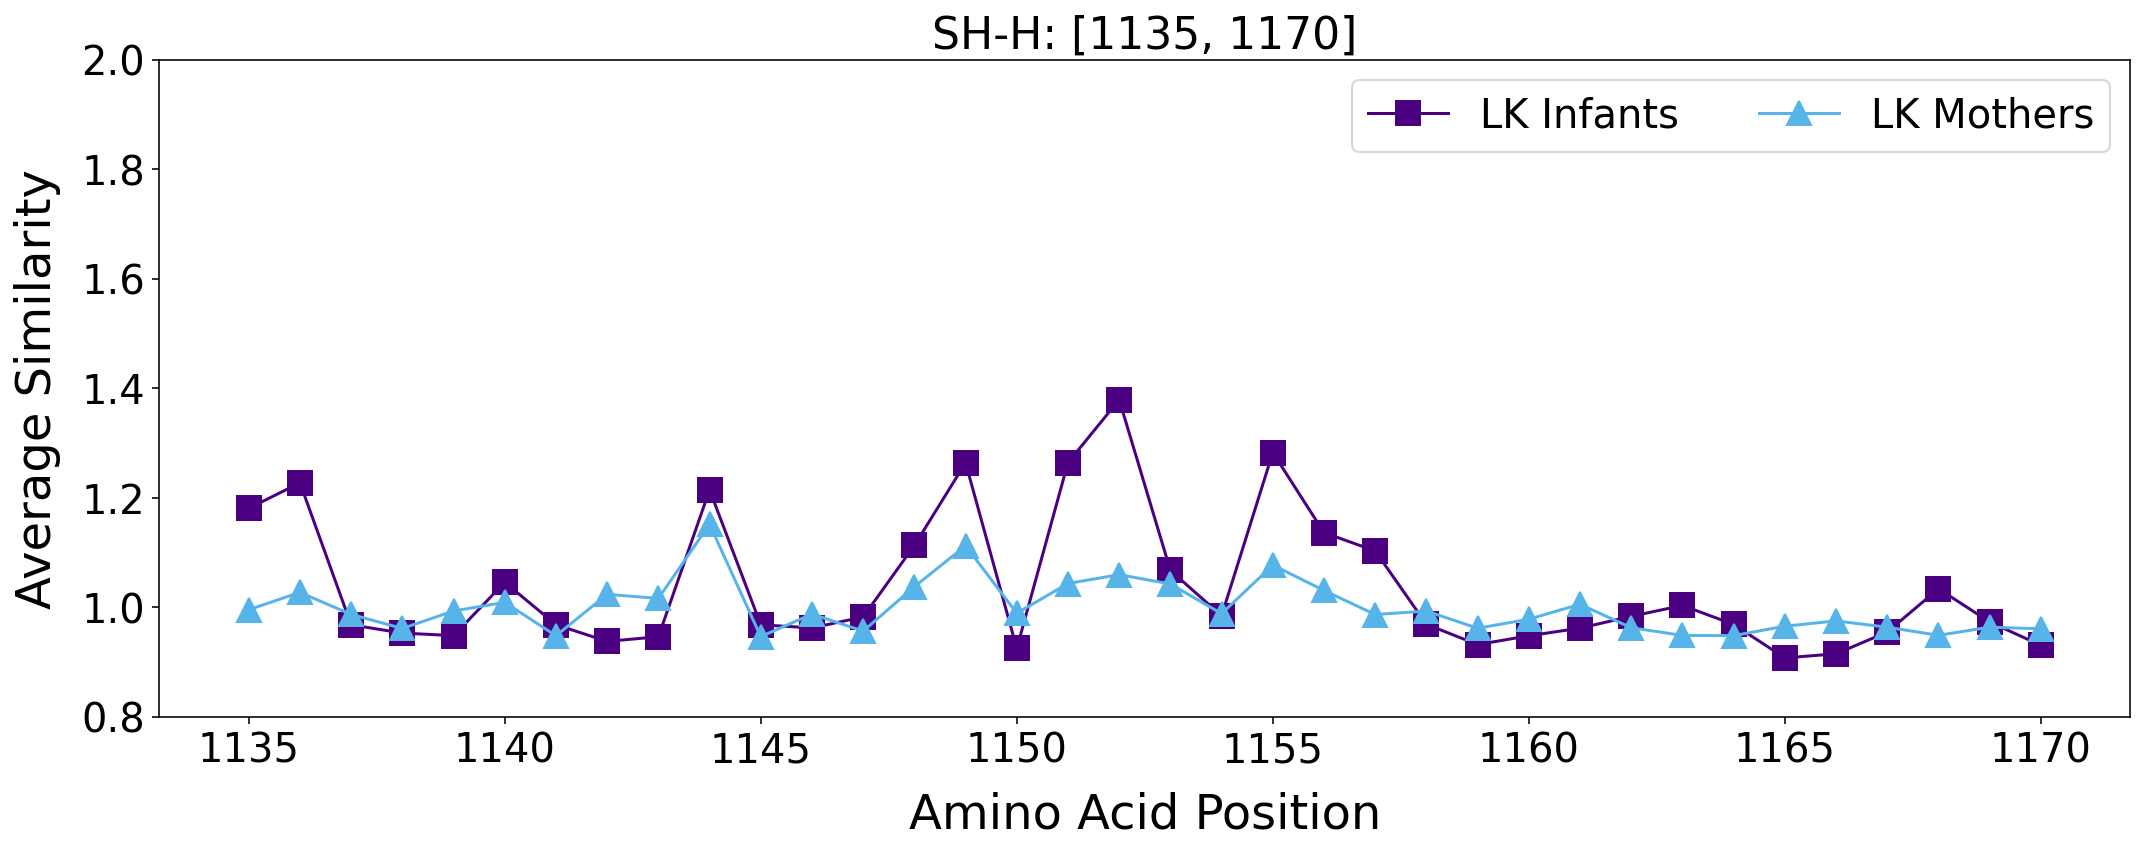

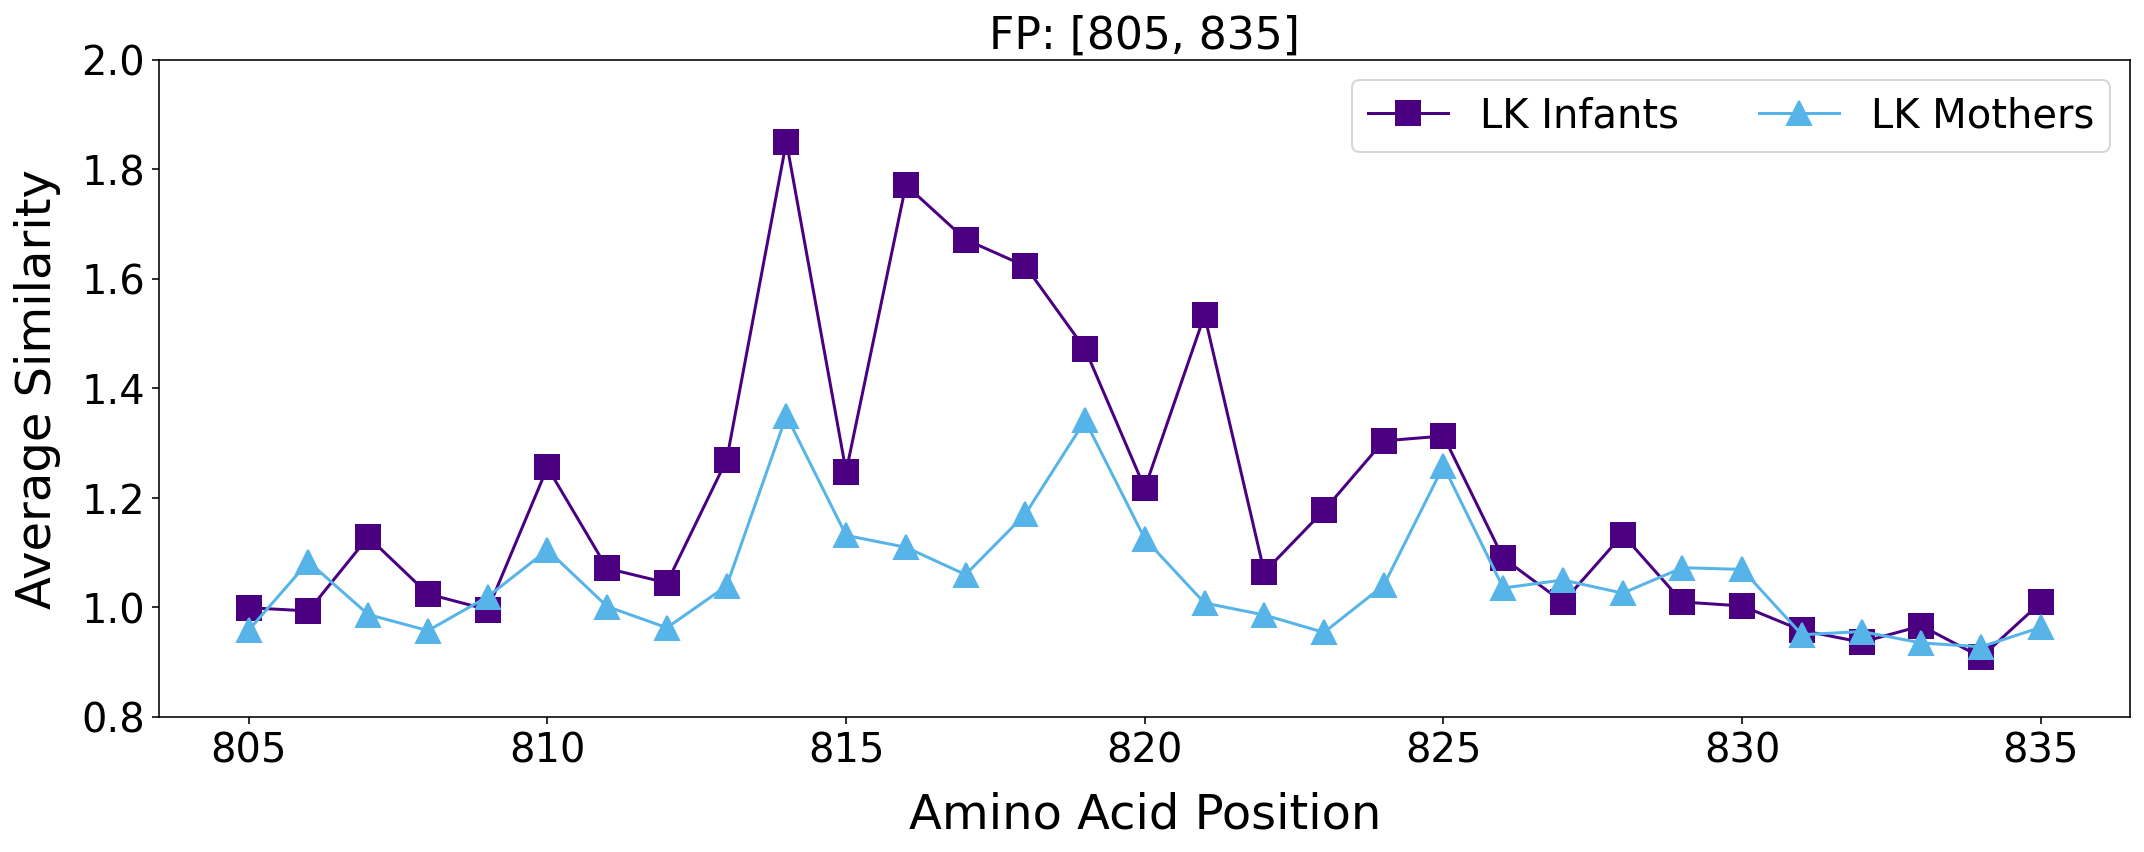

In [7]:
region_list = ['SHH','FP']
group_list  = [lk_infant_sams, lk_mother_sams]
key_list    = ['infants', 'mothers']
label_list  = ['LK Infants', 'LK Mothers']

sim_df = pd.DataFrame(columns=['person','region','position','avg_sim'])

for region in region_list:
    region_groups_sim={}  # per-cohort, per-site, per-individual similarity scores for this epitope region
    
    for group, key, label in zip(group_list, key_list, label_list):

        region_sim=[]  # per-site, per-individual similarity scores for this cohort

        for loc in range(epitope_limits[region][0], epitope_limits[region][1]+1):    
            loc_sim=[]  # per-individual similarity scores for this site

            for sid1 in group:
                esc_data1 = get_loc_escape_data(ds,sid1,loc)

                for sid2 in group:
                    if sid1>=sid2: continue
                    esc_data2 = get_loc_escape_data(ds,sid2,loc)
                    a = esc_data1/np.sum(esc_data1)
                    b = esc_data2/np.sum(esc_data2)
                    cost = ot.emd2(a,b,cost_matrix)
                    loc_sim.append(1./cost)

            region_sim.append(loc_sim)
            sim_df.loc[len(sim_df)] = [key[:-1], region, loc, np.mean(loc_sim)]

        region_groups_sim[key] = copy.deepcopy(region_sim)


    # plotting
    if region=='SHH':
        plotting_keys    = ['infants', 'mothers']
        plotting_labels  = ['LK Infants', 'LK Mothers']
        plotting_colors  = ['indigo', oi_skyblue]
        plotting_markers = ['s', '^']
        ymin2 = 0.8
        ymax2 = 2
        legncol = 2

    elif region=='FP':
        plotting_keys    = ['infants', 'mothers']
        plotting_labels  = ['LK Infants', 'LK Mothers']
        plotting_colors  = ['indigo', oi_skyblue]
        plotting_markers = ['s', '^']
        ymin2 = 0.8
        ymax2 = 2
        legncol = 2

    plotting_sim=[]

    for key in plotting_keys:
        plotting_sim.append(region_groups_sim[key])

    plot_avg_sim(
        region_groups_sim = plotting_sim,
        groups_colors     = plotting_colors,
        groups_markers    = plotting_markers,
        groups_labels     = plotting_labels,
        region            = region,
        ymin_sim          = ymin2,
        ymax_sim          = ymax2,
        legncol           = 2,
        draw              = True,
        out               = None
    )
    
sim_df.to_csv(f'{outdir}/avg_sim.csv',index=False)